In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import alphalens as al
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')
from load_data import is_etf, get_all_symbols, read_and_process_all_stocks, validate_symbols, prepare_alphalens_format, analyze_factor

In [2]:
base_path = '/Users/mouyasushi/k_data/永豐'

In [3]:
master_data = read_and_process_all_stocks(base_path)

Total symbols found: 405
ETFs excluded: 45
Stocks remaining: 405

Reading stock data...


  0%|          | 0/405 [00:00<?, ?it/s]

100%|██████████| 405/405 [01:07<00:00,  6.02it/s]



Final data shape: (729, 405)
Date range: 2021-10-14 00:00:00 to 2024-10-14 00:00:00


In [4]:
master_data   # dict 

{'open':              1101   1102   1104  1210  1215  1216    1225   1227  1229   1231  \
 ts                                                                              
 2021-10-14    NaN    NaN  20.75  53.6   NaN   NaN   50.90  51.10  54.8   66.7   
 2021-10-15  50.00  45.50  20.90  54.0   NaN  68.0   50.30  51.60  54.5   66.1   
 2021-10-18  50.10  45.60  20.75  53.9  79.2  68.1   49.15  51.50  54.5   66.0   
 2021-10-19  49.85  45.45  20.70  54.5  79.8  68.3   51.30  51.50  54.9   65.3   
 2021-10-20  48.85  45.00  20.55  54.5  80.3  67.9   51.50  51.80  56.1   66.8   
 ...           ...    ...    ...   ...   ...   ...     ...    ...   ...    ...   
 2024-10-07  33.80  47.40  30.50  52.1  96.8  87.5  138.50  39.20  61.2  111.5   
 2024-10-08  33.25  47.30  30.70  52.1  98.4  86.6  125.00  39.25  60.9  112.5   
 2024-10-09  32.90  47.40  30.80  52.0  98.4  86.7  117.00  38.70  61.1  112.5   
 2024-10-11  32.75  46.50  30.60  52.0  97.3  88.7  114.50  38.50  60.8  113.0   
 2024-10

In [5]:
master_close = master_data['close']
master_open = master_data['open']
master_high = master_data['high']
master_low = master_data['low']

In [6]:
path = "/Users/mouyasushi/Desktop/Factor/alpha_lens/alphalens/alphalens/my_research/data"
# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Save each DataFrame to CSV
master_close_path = os.path.join(path, "master_close.csv")
master_open_path = os.path.join(path, "master_open.csv")
master_high_path = os.path.join(path, "master_high.csv")
master_low_path = os.path.join(path, "master_low.csv")

master_close.to_csv(master_close_path)
master_open.to_csv(master_open_path)
master_high.to_csv(master_high_path)
master_low.to_csv(master_low_path)

print(f"DataFrames saved as CSV at {path}")

DataFrames saved as CSV at /Users/mouyasushi/Desktop/Factor/alpha_lens/alphalens/alphalens/my_research/data


### Factor : mom6

In [7]:
def calculate_mom6(master_data):
    """
    Calculate the 6-month momentum factor (MOM6) for each stock.

    Note:
    - t is daily
    - Rebalance period: 126 days = 6 months
    - Uses close prices
    - Accounts for market pressure effect from large capital inflows
    - Considers market liquidity impact
    """
    # Get close prices
    close = master_data['close'].copy()

    # Calculate daily returns
    daily_returns = close.pct_change()

    # Calculate 6-month momentum using rolling window
    def mom6_calculation(window):
        """Calculate momentum for a given window of returns"""
        # Require at least 80% of data (101 days)
        min_valid = int(126 * 0.8)
        if len(window.dropna()) < min_valid:
            return np.nan
        # Calculate cumulative return using product of (1 + daily_returns)
        cum_return = (1 + window).prod() - 1
        return cum_return if np.isfinite(cum_return) else np.nan

    # Apply rolling calculation
    factor = daily_returns.rolling(
        window=126,  # 6 months
        min_periods=int(126 * 0.8)  # Require at least 80% of data
    ).apply(mom6_calculation, raw=False)

    # Shift by 1 to avoid look-ahead bias
    factor = factor.shift(1)

    # Clean and standardize factor
    # 1. Remove infinite values
    factor = factor.replace([np.inf, -np.inf], np.nan)

    # 2. Cross-sectional standardization
    for dt in factor.index:
        valid_data = factor.loc[dt].dropna()
        if len(valid_data) >= 10:  # Need at least 10 stocks for meaningful standardization
            mean = valid_data.mean()
            std = valid_data.std()
            if std > 0:
                factor.loc[dt, valid_data.index] = (valid_data - mean) / std
            else:
                factor.loc[dt, valid_data.index] = 0  # Assign zero if std is zero

    # 3. Winsorize extreme values at 1% and 99%
    valid_data = factor.stack().dropna()
    if len(valid_data) > 0:
        lower = valid_data.quantile(0.01)
        upper = valid_data.quantile(0.99)
        factor = factor.clip(lower=lower, upper=upper)

    return factor


In [8]:
def test_mom6_factor(master_data):
    """Test the MOM6 factor calculation"""
    # Calculate factor
    mom6 = calculate_mom6(master_data)

    # Print summary statistics
    print("\nMOM6 Factor Summary:")
    print(f"Total values: {mom6.size}")
    print(f"NaN values: {mom6.isna().sum().sum()}")
    print(f"Non-NaN values: {mom6.notna().sum().sum()}")

    # Show sample of results for first 5 stocks
    print("\nSample factor values (first 5 stocks):")
    print(mom6.iloc[126:131, :5])

    # Show factor statistics
    valid_data = mom6.stack().dropna()
    print("\nFactor Statistics:")
    print(valid_data.describe())

    return mom6


### Load in saved data 

In [9]:
test_mom6_factor(master_data)


MOM6 Factor Summary:
Total values: 295245
NaN values: 43836
Non-NaN values: 251409

Sample factor values (first 5 stocks):
                1101      1102      1104      1210      1215
ts                                                          
2022-04-22 -0.646412 -0.205593 -0.438588 -0.327518 -0.295231
2022-04-25 -0.646050 -0.191315 -0.405790 -0.295013 -0.239928
2022-04-26 -0.528033 -0.082664 -0.284551 -0.214040 -0.120563
2022-04-27 -0.507733 -0.050861 -0.249576 -0.277985 -0.152652
2022-04-28 -0.379124  0.080457 -0.170410 -0.237333 -0.099336

Factor Statistics:
count    251409.000000
mean         -0.009353
std           0.901308
min          -1.621734
25%          -0.551426
50%          -0.211494
75%           0.321129
max           3.847692
dtype: float64


1101      1102      1104      1210      1215      1216  \
ts                                                                       
2021-10-14       NaN       NaN       NaN       NaN       NaN       NaN   
2021-10-15       NaN       NaN       NaN       NaN       NaN       NaN   
2021-10-18       NaN       NaN       NaN       NaN       NaN       NaN   
2021-10-19       NaN       NaN       NaN       NaN       NaN       NaN   
2021-10-20       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-10-07 -0.129454  0.137047 -0.365898 -0.524509 -0.616076  0.059301   
2024-10-08 -0.166615  0.098642 -0.355028 -0.531004 -0.573232  0.085179   
2024-10-09 -0.148710  0.157102 -0.336308 -0.503565 -0.593942  0.168081   
2024-10-11 -0.182185  0.129210 -0.362806 -0.474917 -0.564427  0.213997   
2024-10-14 -0.189858  0.065837 -0.414663 -0.478481 -0.505768  0.190856   

                1225      1227      1229      1231  ...      9914      9930  \
ts                                                  ...                       
2021-10-14       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2021-10-15       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2021-10-18       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2021-10-19       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2021-10-20       NaN       NaN       NaN       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2024-10-07  3.167650 -0.191373 -0.508212  0.091804  ... -0.219514 -0.053300   
2024-10-08  2.795929 -0.227925 -0.513676  0.056040  ... -0.256040  0.032529   
2024-10-09  2.504758 -0.217848 -0.492391  0.107871  ... -0.181698  0.030412   
2024-10-11  2.458276 -0.208861 -0.473234  0.185513  ... -0.180868  0.034680   
2024-10-14  2.202067 -0.251224 -0.468315  0.160139  ... -0.316508  0.051687   

                9933      9937      9938      9939      9940      9941  \
ts                                                                       
2021-10-14       NaN       NaN       NaN       NaN       NaN       NaN   
2021-10-15       NaN       NaN       NaN       NaN       NaN       NaN   
2021-10-18       NaN       NaN       NaN       NaN       NaN       NaN   
2021-10-19       NaN       NaN       NaN       NaN       NaN       NaN   
2021-10-20       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-10-07 -0.309636 -0.274789  0.515283  0.071273 -0.271525 -0.200823   
2024-10-08 -0.244404 -0.294067  0.637026  0.023880 -0.211893 -0.248476   
2024-10-09 -0.243759 -0.269437  0.687917 -0.000283 -0.217007 -0.211864   
2024-10-11 -0.321197 -0.293550  0.736938 -0.012688 -0.206303 -0.210198   
2024-10-14 -0.304540 -0.254536  0.593568 -0.136037 -0.223758 -0.325083   

                9945      9958  
ts                              
2021-10-14       NaN       NaN  
2021-10-15       NaN       NaN  
2021-10-18       NaN       NaN  
2021-10-19       NaN       NaN  
2021-10-20       NaN       NaN  
...              ...       ...  
2024-10-07  0.673355 -0.209398  
2024-10-08  0.668739 -0.197580  
2024-10-09  0.718552 -0.207627  
2024-10-11  0.771524 -0.280067  
2024-10-14  0.809120 -0.206419  

[729 rows x 405 columns]

In [10]:
mom6 = calculate_mom6(master_data)
mom6.tail()

1101      1102      1104      1210      1215      1216  \
ts                                                                       
2024-10-07 -0.129454  0.137047 -0.365898 -0.524509 -0.616076  0.059301   
2024-10-08 -0.166615  0.098642 -0.355028 -0.531004 -0.573232  0.085179   
2024-10-09 -0.148710  0.157102 -0.336308 -0.503565 -0.593942  0.168081   
2024-10-11 -0.182185  0.129210 -0.362806 -0.474917 -0.564427  0.213997   
2024-10-14 -0.189858  0.065837 -0.414663 -0.478481 -0.505768  0.190856   

                1225      1227      1229      1231  ...      9914      9930  \
ts                                                  ...                       
2024-10-07  3.167650 -0.191373 -0.508212  0.091804  ... -0.219514 -0.053300   
2024-10-08  2.795929 -0.227925 -0.513676  0.056040  ... -0.256040  0.032529   
2024-10-09  2.504758 -0.217848 -0.492391  0.107871  ... -0.181698  0.030412   
2024-10-11  2.458276 -0.208861 -0.473234  0.185513  ... -0.180868  0.034680   
2024-10-14  2.202067 -0.251224 -0.468315  0.160139  ... -0.316508  0.051687   

                9933      9937      9938      9939      9940      9941  \
ts                                                                       
2024-10-07 -0.309636 -0.274789  0.515283  0.071273 -0.271525 -0.200823   
2024-10-08 -0.244404 -0.294067  0.637026  0.023880 -0.211893 -0.248476   
2024-10-09 -0.243759 -0.269437  0.687917 -0.000283 -0.217007 -0.211864   
2024-10-11 -0.321197 -0.293550  0.736938 -0.012688 -0.206303 -0.210198   
2024-10-14 -0.304540 -0.254536  0.593568 -0.136037 -0.223758 -0.325083   

                9945      9958  
ts                              
2024-10-07  0.673355 -0.209398  
2024-10-08  0.668739 -0.197580  
2024-10-09  0.718552 -0.207627  
2024-10-11  0.771524 -0.280067  
2024-10-14  0.809120 -0.206419  

[5 rows x 405 columns]

In [11]:
price_df = master_data['close']
price_df, factor_data = prepare_alphalens_format(mom6, price_df)

In [12]:
import alphalens as al

# Define the periods over which you want to calculate forward returns
periods = (1, 5, 10, 20, 40, 60)  # 1-day, 5-day, 10-day, and 21-day holding periods

# Align and clean the data
factor_data_aligned = al.utils.get_clean_factor_and_forward_returns(
    factor=factor_data,
    prices=price_df,
    periods=periods,
    quantiles=10,         # Number of quantiles to use
    filter_zscore=20,    # Z-score filtering threshold
    max_loss=0.1        # Maximum allowable data loss
)

Dropped 9.6% entries from factor data: 9.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 10.0%, not exceeded: OK!


In [13]:
# Series: required form 
""" 
index : date, asset 
column : factor 
"""
factor_data

date        asset
2022-03-16  1104    -0.323197
            1210    -0.503946
            1225     0.487352
            1227    -0.729785
            1229     0.512701
                       ...   
2024-10-14  9939    -0.136037
            9940    -0.223758
            9941    -0.325083
            9945     0.809120
            9958    -0.206419
Name: factor, Length: 251409, dtype: float64

In [14]:
factor_data_aligned

1D        5D       10D       20D       40D       60D  \
date       asset                                                               
2022-03-16 1104   0.009501  0.009501  0.014252 -0.004751  0.002375  0.030879   
           1210   0.007634  0.020992  0.038168  0.055344 -0.098282 -0.088740   
           1225   0.031634  0.022847  0.036907  0.079086 -0.115993 -0.163445   
           1227   0.015593  0.015593  0.037422  0.058212  0.003119 -0.043659   
           1229   0.009554  0.033439  0.025478  0.066879 -0.146497 -0.109873   
...                    ...       ...       ...       ...       ...       ...   
2024-07-12 9939  -0.003067  0.049080 -0.036810 -0.018405 -0.021472 -0.036810   
           9940  -0.007541 -0.019608  0.001508 -0.007541 -0.070890 -0.079940   
           9941   0.023411  0.013378  0.023411  0.016722 -0.137124 -0.050167   
           9945  -0.006424  0.028908  0.102784  0.029979 -0.036403  0.004283   
           9958  -0.034608 -0.072860 -0.198543 -0.256831 -0.255009 -0.160291   

                    factor  factor_quantile  
date       asset                             
2022-03-16 1104  -0.323197                5  
           1210  -0.503946                3  
           1225   0.487352                8  
           1227  -0.729785                2  
           1229   0.512701                8  
...                    ...              ...  
2024-07-12 9939  -0.031864                7  
           9940  -0.359233                5  
           9941  -0.896053                1  
           9945  -0.178676                6  
           9958   0.486943                9  

[227168 rows x 8 columns]

### Check for Nan and inf in : 
- factor_data_aligned['factor']

In [15]:
# Check for NaNs in factor values
nans_in_factor = factor_data_aligned['factor'].isnull().sum()
print(f"Number of NaNs in factor data: {nans_in_factor}")

# Check for infinite values in factor values
inf_in_factor = np.isinf(factor_data_aligned['factor']).sum()
print(f"Number of infinite values in factor data: {inf_in_factor}")


Number of NaNs in factor data: 0
Number of infinite values in factor data: 0


In [16]:
# Identify forward return columns
forward_return_columns = factor_data_aligned.filter(regex='^[0-9]+[DWM]').columns


In [17]:
# col for forward returns 

forward_return_columns

Index(['1D', '5D', '10D', '20D', '40D', '60D'], dtype='object')

In [18]:
# Check for NaNs and infinities in forward returns
for col in forward_return_columns:
    nans_in_returns = factor_data_aligned[col].isnull().sum()
    inf_in_returns = np.isinf(factor_data_aligned[col]).sum()
    print(f"Column {col}: {nans_in_returns} NaNs, {inf_in_returns} infinite values")

Column 1D: 0 NaNs, 3 infinite values
Column 5D: 0 NaNs, 3 infinite values
Column 10D: 0 NaNs, 3 infinite values
Column 20D: 0 NaNs, 3 infinite values
Column 40D: 0 NaNs, 3 infinite values
Column 60D: 0 NaNs, 3 infinite values


In [19]:
# Replace infinite values with NaN in the forward returns columns
factor_data_aligned[forward_return_columns] = factor_data_aligned[forward_return_columns].replace([np.inf, -np.inf], np.nan)

In [20]:
factor_data_aligned[forward_return_columns]

1D        5D       10D       20D       40D       60D
date       asset                                                            
2022-03-16 1104   0.009501  0.009501  0.014252 -0.004751  0.002375  0.030879
           1210   0.007634  0.020992  0.038168  0.055344 -0.098282 -0.088740
           1225   0.031634  0.022847  0.036907  0.079086 -0.115993 -0.163445
           1227   0.015593  0.015593  0.037422  0.058212  0.003119 -0.043659
           1229   0.009554  0.033439  0.025478  0.066879 -0.146497 -0.109873
...                    ...       ...       ...       ...       ...       ...
2024-07-12 9939  -0.003067  0.049080 -0.036810 -0.018405 -0.021472 -0.036810
           9940  -0.007541 -0.019608  0.001508 -0.007541 -0.070890 -0.079940
           9941   0.023411  0.013378  0.023411  0.016722 -0.137124 -0.050167
           9945  -0.006424  0.028908  0.102784  0.029979 -0.036403  0.004283
           9958  -0.034608 -0.072860 -0.198543 -0.256831 -0.255009 -0.160291

[227168 rows x 6 columns]

In [21]:
# Drop rows with NaNs in any of the forward return columns
factor_data_aligned.dropna(subset=forward_return_columns, inplace=True)

In [22]:
# Check if all the inf, Nans are dropped 
for col in forward_return_columns:
    nans_in_returns = factor_data_aligned[col].isnull().sum()
    inf_in_returns = np.isinf(factor_data_aligned[col]).sum()
    print(f"Column {col}: {nans_in_returns} NaNs, {inf_in_returns} infinite values")


Column 1D: 0 NaNs, 0 infinite values
Column 5D: 0 NaNs, 0 infinite values
Column 10D: 0 NaNs, 0 infinite values
Column 20D: 0 NaNs, 0 infinite values
Column 40D: 0 NaNs, 0 infinite values
Column 60D: 0 NaNs, 0 infinite values


### Run Backtest

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -1.621734 -0.671938 -1.127029  0.276080  23045  10.144609
2               -1.328150 -0.504838 -0.753412  0.135286  22639   9.965884
3               -0.911206 -0.343810 -0.556519  0.073568  22557   9.929787
4               -0.590558 -0.156406 -0.407126  0.074762  22715   9.999340
5               -0.461108  0.047317 -0.267368  0.101382  22812  10.042040
6               -0.338499  0.268565 -0.113099  0.126054  22534   9.919662
7               -0.203751  0.548645  0.069915  0.142209  22697   9.991416
8               -0.040057  0.795606  0.316048  0.151200  22572   9.936390
9                0.280200  1.270481  0.730208  0.186225  22624   9.959281
10               0.817755  3.847692  2.021435  0.894080  22970  10.111593

Returns Analysis


1D      5D     10D     20D  \
Ann. alpha                                      0.135   0.141   0.131   0.121   
beta                                            0.095   0.035   0.065   0.090   
Mean Period Wise Return Top Quantile (bps)      8.801   8.489   7.848   8.210   
Mean Period Wise Return Bottom Quantile (bps)  -4.638  -4.754  -5.423  -5.275   
Mean Period Wise Spread (bps)                  13.439  13.037  13.031  13.221   

                                                  40D     60D  
Ann. alpha                                      0.127   0.109  
beta                                            0.075   0.116  
Mean Period Wise Return Top Quantile (bps)      8.132   7.642  
Mean Period Wise Return Bottom Quantile (bps)  -5.264  -4.630  
Mean Period Wise Spread (bps)                  13.226  12.180

<Figure size 640x480 with 0 Axes>

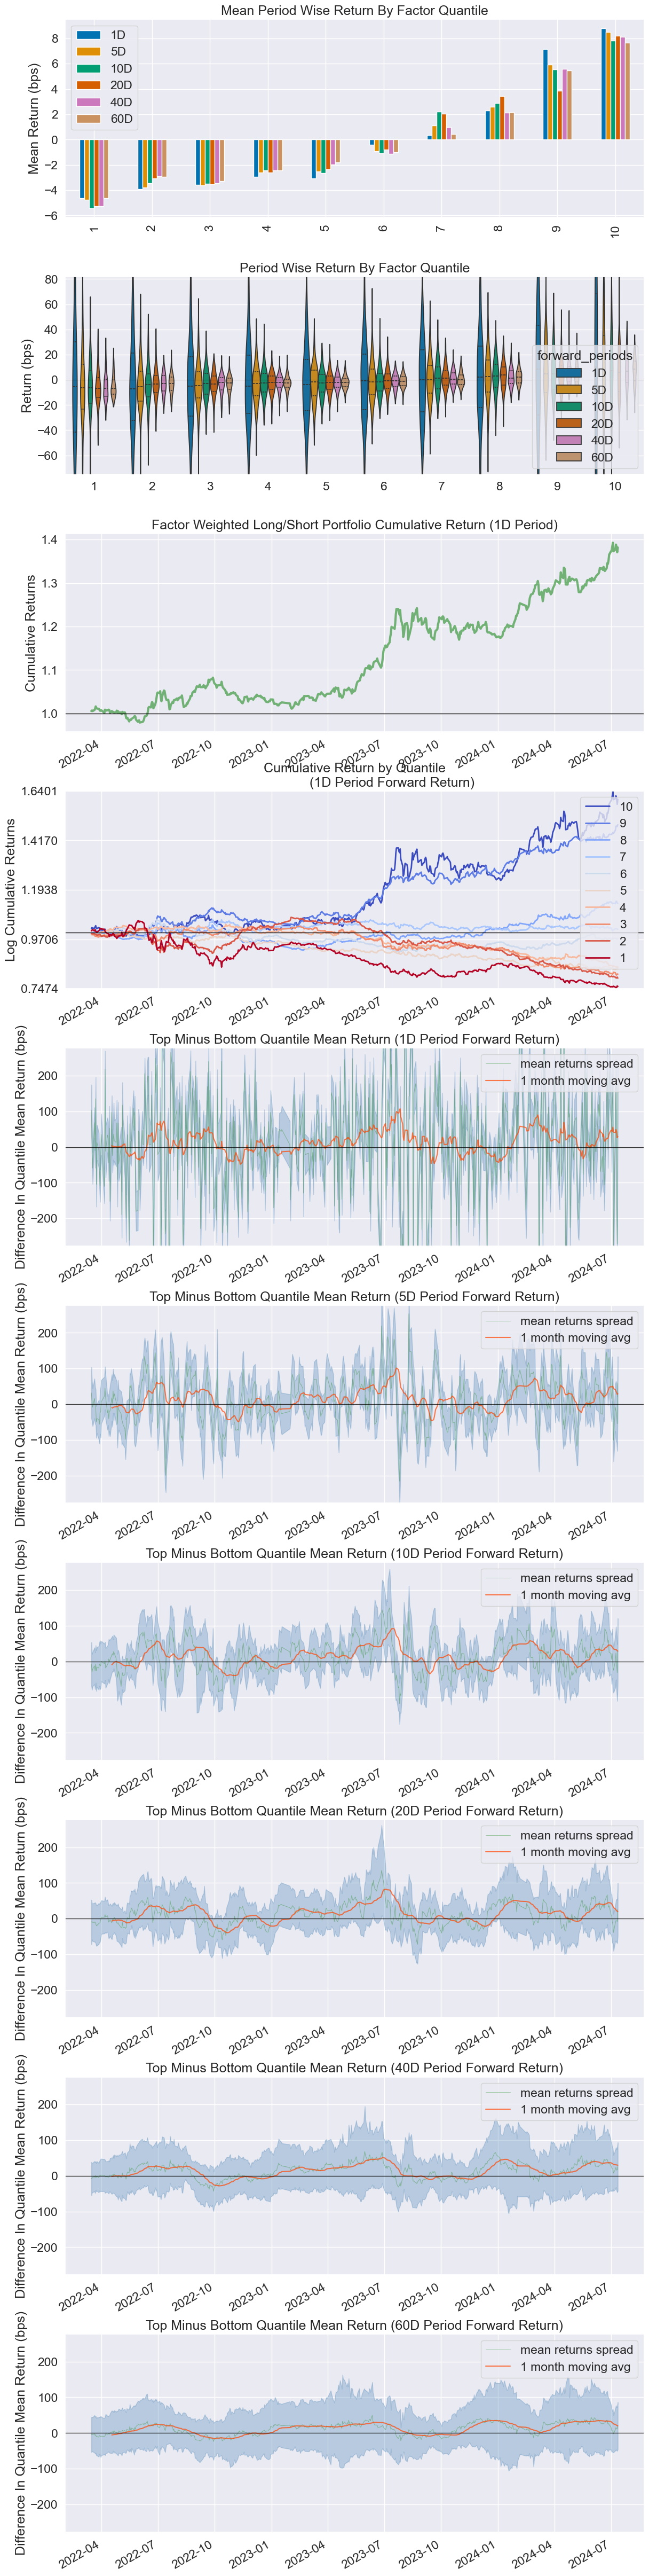

Information Analysis


1D     5D    10D    20D    40D    60D
IC Mean           0.006  0.015  0.022  0.031  0.050  0.056
IC Std.           0.171  0.178  0.169  0.162  0.166  0.169
Risk-Adjusted IC  0.037  0.082  0.129  0.190  0.302  0.334
t-stat(IC)        0.893  1.954  3.071  4.518  7.193  7.968
p-value(IC)       0.372  0.051  0.002  0.000  0.000  0.000
IC Skew          -0.222 -0.147 -0.023 -0.197 -0.393 -0.474
IC Kurtosis       0.039 -0.182 -0.694 -0.363 -0.258 -0.277

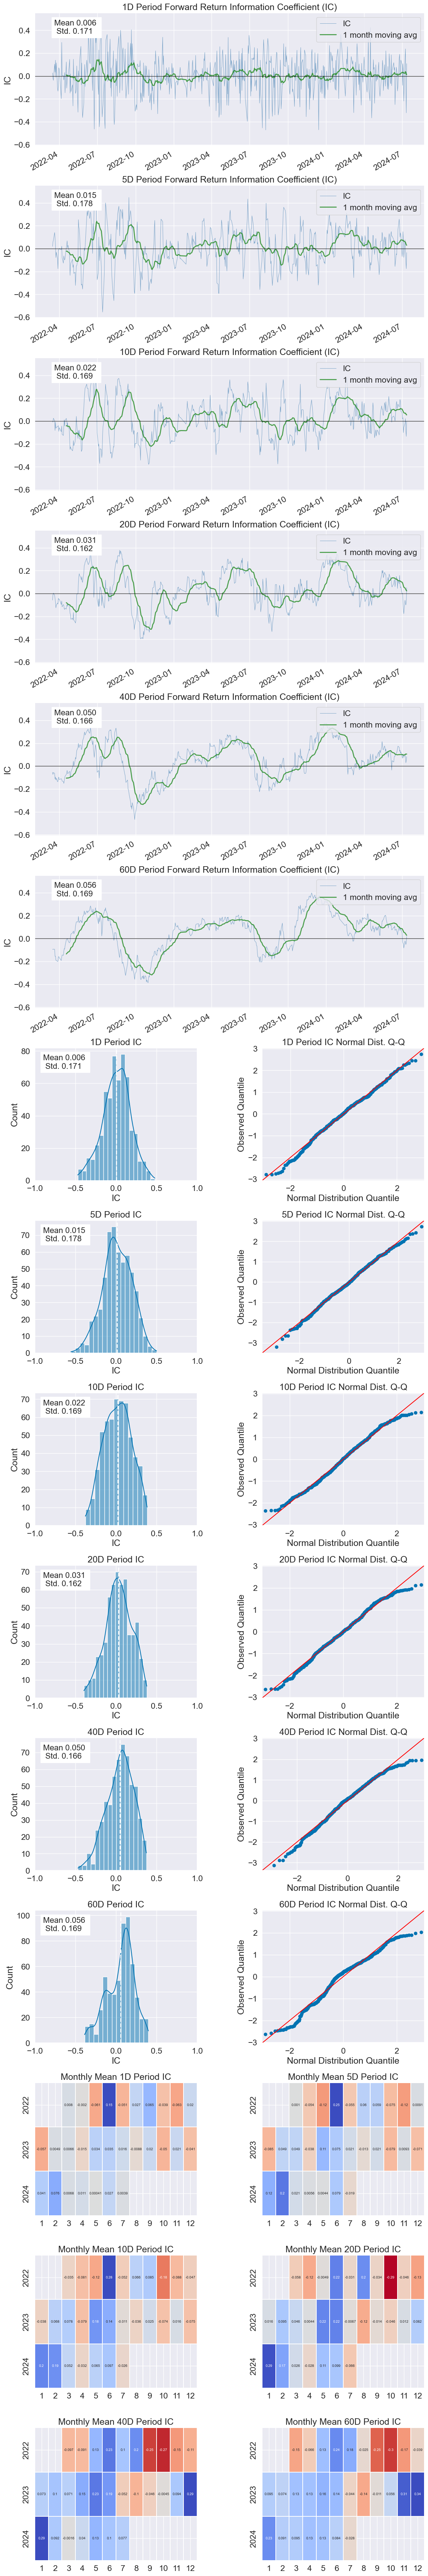

Turnover Analysis


1D     5D    10D    20D    40D    60D
Quantile 1 Mean Turnover    0.091  0.197  0.273  0.377  0.519  0.637
Quantile 2 Mean Turnover    0.228  0.441  0.554  0.660  0.745  0.805
Quantile 3 Mean Turnover    0.291  0.527  0.630  0.728  0.801  0.835
Quantile 4 Mean Turnover    0.326  0.559  0.664  0.754  0.823  0.839
Quantile 5 Mean Turnover    0.335  0.575  0.679  0.762  0.823  0.862
Quantile 6 Mean Turnover    0.323  0.570  0.683  0.769  0.828  0.850
Quantile 7 Mean Turnover    0.295  0.535  0.651  0.750  0.822  0.847
Quantile 8 Mean Turnover    0.245  0.474  0.592  0.710  0.792  0.830
Quantile 9 Mean Turnover    0.179  0.369  0.486  0.604  0.722  0.792
Quantile 10 Mean Turnover   0.072  0.156  0.222  0.314  0.452  0.569

1D     5D    10D    20D    40D    60D
Mean Factor Rank Autocorrelation  0.99  0.954  0.912  0.831  0.675  0.518

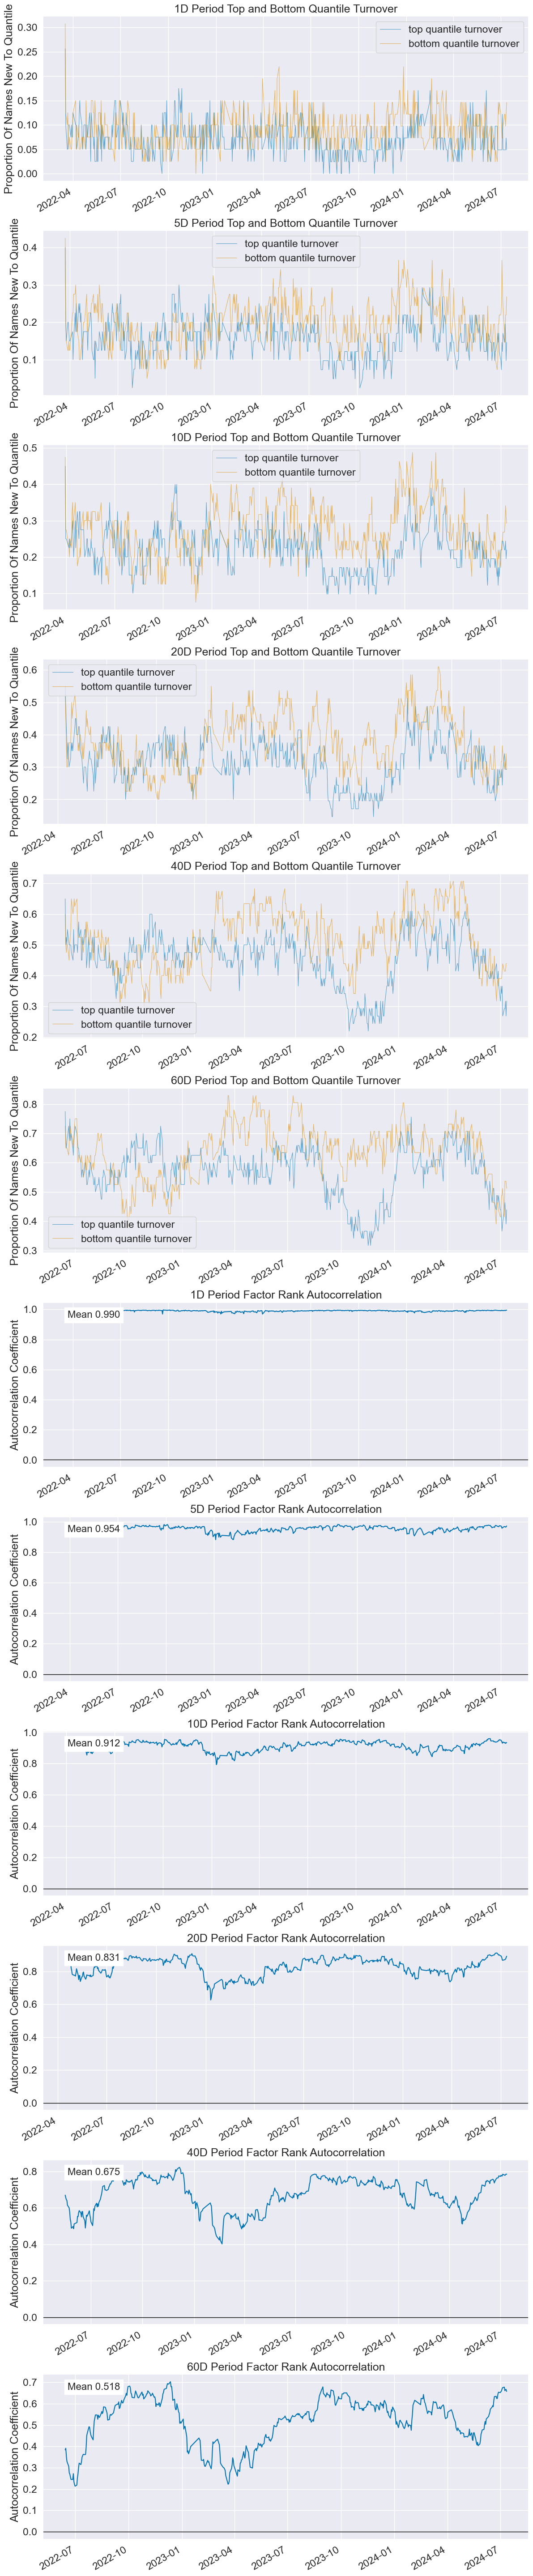

In [23]:
# Generate the full tear sheet
al.tears.create_full_tear_sheet(
    factor_data=factor_data_aligned,
    long_short=True,     # Analyze in a long-short context
    group_neutral=False, # Set to True if you have group data and want to neutralize groups
    by_group=False, # Set to True if you want analysis by group --> we don't have data for now 
)


### Summary 

Metric	1D	5D	10D	21D \
Spread (bps)	12.173	11.258	10.870	10.009 \
IC Mean	0.006	0.014	0.021	0.031 \
Risk-Adjusted IC	0.037	0.081	0.129	0.195 \
t-stat(IC)	0.906	1.996	3.182	4.799 \
p-value(IC)	0.365	0.046	0.002	0.000 \
Rank Autocorrelation	0.990	0.955	0.914	0.826 \ 
Top Quantile Mean Return	7.694	6.947	6.409	5.894 \ 
Bottom Quantile Mean Return	-4.479	-4.387	-4.544	-4.183 \ 

### Quantile analysis 

In [24]:
import alphalens as al 

al.plotting.plot_quantile_statistics_table(factor_data_aligned)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -1.621734 -0.671938 -1.127029  0.276080  23045  10.144609
2               -1.328150 -0.504838 -0.753412  0.135286  22639   9.965884
3               -0.911206 -0.343810 -0.556519  0.073568  22557   9.929787
4               -0.590558 -0.156406 -0.407126  0.074762  22715   9.999340
5               -0.461108  0.047317 -0.267368  0.101382  22812  10.042040
6               -0.338499  0.268565 -0.113099  0.126054  22534   9.919662
7               -0.203751  0.548645  0.069915  0.142209  22697   9.991416
8               -0.040057  0.795606  0.316048  0.151200  22572   9.936390
9                0.280200  1.270481  0.730208  0.186225  22624   9.959281
10               0.817755  3.847692  2.021435  0.894080  22970  10.111593

### Quant stat quick BT 

In [25]:
pf_returns, pf_positions, pf_benchmark = \
    al.performance.create_pyfolio_input(factor_data_aligned,
                                        period='1D',
                                        capital=1000000,
                                        long_short=True,
                                        group_neutral=False,
                                        equal_weight=True,
                                        quantiles=[1,10],
                                        groups=None,
                                        benchmark_period='1D')

In [26]:
print(pf_returns)
print(pf_benchmark)

date
2022-03-16    0.000000
2022-03-17    0.000733
2022-03-18   -0.002950
2022-03-19    0.000000
2022-03-20    0.000000
                ...   
2024-07-08    0.004001
2024-07-09    0.008774
2024-07-10   -0.006462
2024-07-11   -0.013568
2024-07-12    0.008264
Freq: D, Length: 850, dtype: float64
date
2022-03-16    0.000000
2022-03-17    0.003559
2022-03-18    0.006603
2022-03-19    0.000000
2022-03-20    0.000000
                ...   
2024-07-08   -0.004260
2024-07-09    0.008498
2024-07-10    0.005096
2024-07-11   -0.004376
2024-07-12    0.000502
Freq: D, Name: benchmark, Length: 850, dtype: float64


In [27]:
end_date = '2024-07-12'
pf_positions = pf_positions[:end_date]
pf_positions.tail()

asset               1304  1442          1560  1707  1712  1773  1909  2006  \
date                                                                         
2024-07-08 -17682.865902   0.0  17682.865902   0.0   0.0   0.0   0.0   0.0   
2024-07-09 -17838.021437   0.0      0.000000   0.0   0.0   0.0   0.0   0.0   
2024-07-10 -17722.750992   0.0      0.000000   0.0   0.0   0.0   0.0   0.0   
2024-07-11 -17482.290418   0.0  17482.290418   0.0   0.0   0.0   0.0   0.0   
2024-07-12 -17626.758144   0.0      0.000000   0.0   0.0   0.0   0.0   0.0   

asset       2049          2344  ...  5534  2258  6177          1723  2809  \
date                            ...                                         
2024-07-08   0.0      0.000000  ...   0.0   0.0   0.0      0.000000   0.0   
2024-07-09   0.0 -17838.021437  ...   0.0   0.0   0.0      0.000000   0.0   
2024-07-10   0.0 -17722.750992  ...   0.0   0.0   0.0      0.000000   0.0   
2024-07-11   0.0 -17482.290418  ...   0.0   0.0   0.0 -17482.290418   0.0   
2024-07-12   0.0 -17626.758144  ...   0.0   0.0   0.0 -17626.758144   0.0   

asset       2881C  2330  6147          2324          cash  
date                                                       
2024-07-08    0.0   0.0   0.0      0.000000  1.449995e+06  
2024-07-09    0.0   0.0   0.0 -17838.021437  1.462718e+06  
2024-07-10    0.0   0.0   0.0 -17722.750992  1.453266e+06  
2024-07-11    0.0   0.0   0.0      0.000000  1.433548e+06  
2024-07-12    0.0   0.0   0.0 -17626.758144  1.445394e+06  

[5 rows x 369 columns]

### create Benchmark using 0050.TW

In [28]:
import yfinance as yf
import pandas as pd 

# Define the ticker, start date, and end date
ticker = '0050.TW'  # Replace with the actual index or stock ticker
start_date = '2022-03-16'
end_date = '2024-07-13'

# Download historical data
real_bench = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [29]:
# Get adjusted close prices
adj_close = real_bench['Adj Close']

# Calculate daily returns
daily_returns = adj_close.pct_change()

# Replace NaN in the first row with 0 to start cumulative returns at 1
daily_returns.iloc[0] = 0

# Convert returns to growth factors and compute cumulative returns
real_benchmark  = daily_returns

# Print cumulative returns
print(real_benchmark.tail())


Date
2024-07-08    0.031543
2024-07-09   -0.001011
2024-07-10    0.003542
2024-07-11    0.022183
2024-07-12   -0.031566
Name: Adj Close, dtype: float64


In [30]:
aligned_returns, aligned_benchmark = pf_returns.align(real_benchmark, join='inner')
aligned_benchmark.to_csv('/Users/mouyasushi/Desktop/Factor/alpha_lens/alphalens/alphalens/my_research/data/aligned_benchmark.csv')


In [31]:
print(type(aligned_returns))  # Should be <class 'pandas.core.series.Series'>
print(type(aligned_benchmark))  # Should be <class 'pandas.core.series.Series'>


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Create Full report 

In [32]:
import quantstats as qs
import pandas as pd

def create_performance_report(returns, benchmark_rets=None, positions=None, output_filename='analysis.html'):
    """
    Create a comprehensive performance report using QuantStats.
    
    Parameters:
    -----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative
    benchmark_rets : pd.Series, optional
        Daily returns of the benchmark
    positions : pd.DataFrame, optional
        Daily position values (not directly used in QuantStats but can be analyzed separately)
    output_filename : str, optional
        Name of the output HTML file
    """
    # Extend pandas functionality with QuantStats
    qs.extend_pandas()
    
    # If benchmark is provided, create a full comparison report
    if benchmark_rets is not None:
        # Create HTML report comparing strategy to benchmark
        qs.reports.html(returns, 
                       benchmark_rets, 
                       output=output_filename,
                       title='Strategy Analysis')
    else:
        # Create HTML report for strategy alone
        qs.reports.html(returns, 
                       output=output_filename,
                       title='Strategy Analysis')
    
    # Print basic metrics to console
    print("\nBasic Performance Metrics:")
    print("-------------------------")
    print(f"Sharpe Ratio: {qs.stats.sharpe(returns):.2f}")
    print(f"Max Drawdown: {qs.stats.max_drawdown(returns):.2%}")
    print(f"Win Rate: {qs.stats.win_rate(returns):.2%}")
    
    # If positions are provided, we can analyze them separately
    if positions is not None:
        print("\nPosition Summary:")
        print("----------------")
        print(f"Average Position Count: {positions.count(axis=1).mean():.2f}")
        print(f"Max Position Count: {positions.count(axis=1).max()}")


# Example usage:
create_performance_report(
    returns=aligned_returns,
    benchmark_rets=aligned_benchmark,
    positions=pf_positions,
    output_filename='strategy_analysis.html'
)

# For additional specific metrics:
def print_detailed_metrics(returns, benchmark_rets=None):
    """Print detailed performance metrics"""
    print("\nDetailed Metrics:")
    print("----------------")
    metrics = {
        'Annual Return': qs.stats.cagr(returns),
        'Volatility': qs.stats.volatility(returns),
    }
    
    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f"{metric}: {value:.2%}" if 'Duration' not in metric else f"{metric}: {value:.0f} days")

# Example usage for detailed metrics:
print_detailed_metrics(aligned_returns, aligned_benchmark)


Basic Performance Metrics:
-------------------------
Sharpe Ratio: 1.53
Max Drawdown: -8.74%
Win Rate: 56.26%

Position Summary:
----------------
Average Position Count: 369.00
Max Position Count: 369

Detailed Metrics:
----------------
Annual Return: 11.38%
Volatility: 10.92%
